# OLS vs Naive con yfinance — Predicción a 100 días


## Objetivos
1. Descargar datos de precios (Close) con `yfinance` (por defecto: AAPL, 1 año diario).
2. Ajustar **OLS** usando `Date (ordinal)` como regresor y mostrar el **summary**.
3. Generar **predicción a 100 días** hacia el futuro.
4. Calcular **MSE** y **RMSE** del ajuste en entrenamiento.
5. Comparar contra un **modelo naive (y_t = y_{t-1})**.
6. Graficar histórico y predicción (matplotlib).

## Marco Teórico

### 1. Mínimos Cuadrados Ordinarios (OLS) Ordinary Least Squares
El modelo lineal simple con una covariable temporal se puede escribir como:
$$
y_t = \beta_0 + \beta_1 x_t + \varepsilon_t,
$$
donde $y_t$ es el precio de cierre, $x_t$ es la fecha en formato **ordinal** (número entero creciente por día), y $\varepsilon_t$ es el error aleatorio con $E[\varepsilon_t]=0$ y $Var(\varepsilon_t)=\sigma^2$.  
OLS estima $\beta_0, \beta_1$ minimizando la suma de errores cuadráticos:

$$
\min_{\beta_0,\beta_1} \sum_{t=1}^n \left(y_t - (\beta_0 + \beta_1 x_t)\right)^2.
$$

El **summary** de `statsmodels` reporta:
- Coeficientes estimados y sus **errores estándar**.
- **Estadísticos t** y **p-valores** para contrastes de significancia.
- **R²** y **R² ajustado** (bondad de ajuste).
- Diagnósticos como el **estadístico F** del modelo.

> Nota: Modelar el precio con una tendencia lineal en la fecha es **muy simplificado**. Aun así, sirve como línea base y para ilustrar métricas.


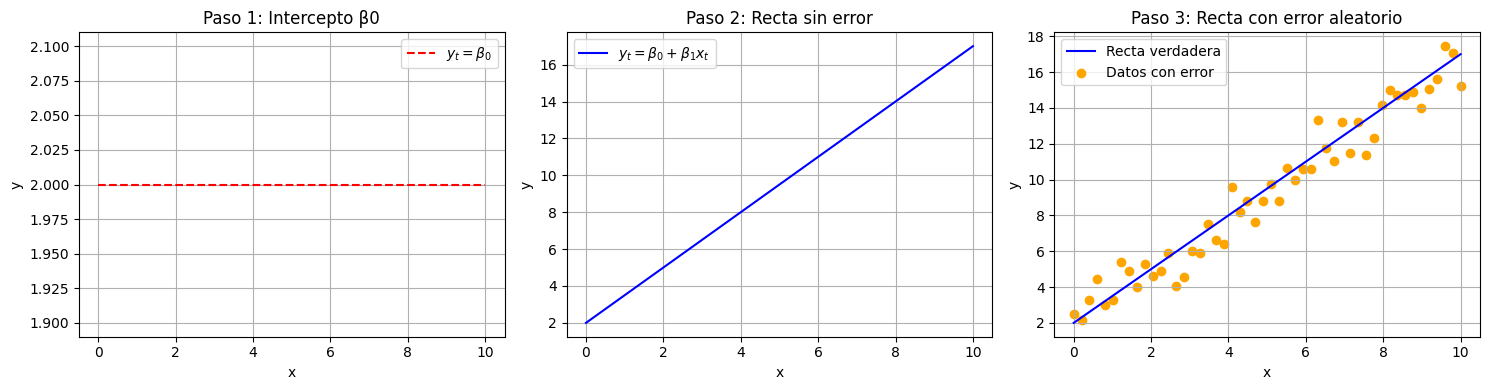

In [1]:
# @title
# ======================================================
# Ecuación lineal: y_t = β0 + β1 x_t + ε_t
# Gráfica paso a paso
# ======================================================

import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 1) Definir parámetros
# -------------------------
np.random.seed(42)   # reproducibilidad
n = 50               # número de observaciones
beta0 = 2            # intercepto
beta1 = 1.5          # pendiente
sigma = 1.0          # desviación del error

# Variable independiente x
x = np.linspace(0, 10, n)

# Error aleatorio ε
epsilon = np.random.normal(0, sigma, n)

# -------------------------
# 2) Construcción paso a paso
# -------------------------
# Paso 1: Intercepto β0
y_step1 = np.repeat(beta0, n)

# Paso 2: Recta sin ruido β0 + β1 x
y_step2 = beta0 + beta1 * x

# Paso 3: Ecuación completa con error
y_step3 = beta0 + beta1 * x + epsilon

# -------------------------
# 3) Graficar paso a paso
# -------------------------

plt.figure(figsize=(15,4))

# Paso 1: intercepto
plt.subplot(1,3,1)
plt.plot(x, y_step1, "r--", label=r"$y_t = \beta_0$")
plt.title("Paso 1: Intercepto β0")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.grid(True)

# Paso 2: recta sin ruido
plt.subplot(1,3,2)
plt.plot(x, y_step2, "b-", label=r"$y_t = \beta_0 + \beta_1 x_t$")
plt.title("Paso 2: Recta sin error")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.grid(True)

# Paso 3: recta con ruido
plt.subplot(1,3,3)
plt.plot(x, y_step2, "b-", label="Recta verdadera")
plt.scatter(x, y_step3, color="orange", label="Datos con error")
plt.title("Paso 3: Recta con error aleatorio")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


### 2. Modelo Naive (Benchmark)
En series de tiempo, un baseline común es:
$$
\hat{y}_t^{(naive)} = y_{t-1},
$$
es decir, se usa el valor de ayer como predicción de hoy. Si un modelo no mejora al naive, **su valor predictivo es cuestionable**.


### 3. Métricas MSE y RMSE
- **MSE** (Error Cuadrático Medio):
$$
\text{MSE} = \frac{1}{n} \sum_{t=1}^n (y_t - \hat{y}_t)^2.
$$
- **RMSE** (Raíz del Error Cuadrático Medio):
$$
\text{RMSE} = \sqrt{\text{MSE}},
$$
devuelve el error en **la misma unidad** que $y$ (p. ej., USD), por lo que es más interpretable.



# 📊 Tabla de referencia para evaluar modelos de predicción financiera (precios)

| Métrica | Bueno ✅ | Aceptable ⚖️ | Malo ❌ | Interpretación |
|---------|---------|--------------|---------|----------------|
| **MAPE** (Error porcentual medio) | $ \leq 2\% $ | $ 2\% \text{ - } 5\% $ | $ > 5\% $ | Indica cuán cerca está el precio predicho del real en porcentaje. |
| **RMSE / MAE** (Error absoluto) | $ \leq 2\% \ \text{del precio actual} $ | $ 2\% \text{ - } 5\% \ \text{del precio actual} $ | $ > 5\% \ \text{del precio actual} $ | Error típico en dólares, comparado con el nivel del activo. |
| $R^2$ (Coeficiente de determinación) | $ > 0.5 $ | $ 0.1 \text{ - } 0.5 $ | $ < 0.1 $ | Mide cuánta variabilidad explica el modelo. En precios debería ser alto; en retornos suele ser bajo. |



### 📊 Valores aceptables en predicción financiera

#### 1. MAPE (error porcentual)

Mide el error en porcentaje respecto al precio real.

	•	Menor a 5% → Excelente.
	•	Entre 5% y 10% → Aceptable.
	•	Mayor a 10% → Ya no es confiable.

👉 Ejemplo: Si AAPL vale 230 USD y el modelo se equivoca en 5 USD,
el MAPE ≈ 2.2% → aceptable.


#### 2. RMSE y MAE (en dólares)

Miden el error absoluto en el mismo nivel del precio.
Lo importante es compararlo con el valor actual del activo:

	•	RMSE o MAE < 2% del precio → Muy bueno.
	•	2%–5% del precio → Aceptable.
	•	> 5% del precio → Demasiado error.

👉 Ejemplo:

	•	AAPL vale 230 USD.
	•	RMSE = 4.5 USD → error ≈ 2% → aceptable.
	•	RMSE = 12 USD → error ≈ 5.2% → límite de lo aceptable.



#### 3. R² (coeficiente de determinación)

Mide qué tanta variabilidad explica el modelo.

	•	R² > 0.5 → Bueno (explica al menos la mitad de los cambios).
	•	R² entre 0.1 y 0.5 → Aceptable, pero limitado.
	•	R² < 0.1 → No confiable.

👉 En retornos diarios casi siempre será bajo, porque son muy aleatorios.
En precios sí debería ser mayor.


#### 📌 Resumen fácil

Para decir que un modelo es aceptable en predicción financiera:

	•	MAPE ≤ 5%
	•	RMSE/MAE ≤ 2–3% del precio
	•	R² ≥ 0.1 (en retornos), mejor si es >0.5 en precios



✅ En el siguiente caso con WLS se obtuvo:

	•	MAPE = 4.2% → Aceptable.
	•	RMSE = 12.5 USD con AAPL en ~237 USD → ≈ 5.3% → justo en el límite de lo aceptable.
	•	R² ≈ 0.01 en retornos → prácticamente no aporta en retornos (normal).



### 4. Predicción a Futuro con OLS
Con el modelo ajustado, para fechas futuras $x_{n+1},\\ldots,x_{n+h}$ (en ordinal), las predicciones puntuales son:
$$
\hat{y}_{n+k} = \hat{\\beta}_0 + \hat{\\beta}_1 x_{n+k}.
$$
> Para **intervalos de confianza** y **predicción**, puede emplearse `get_prediction()` de `statsmodels`.

In [2]:
# !pip install yfinance statsmodels scikit-learn matplotlib --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# =========================
# Parámetros
# =========================
TICKER   = "MELI" #AAPL
PERIOD   = "4y"   # '1y', '2y', '5y', etc.
INTERVAL = "1d"   # '1d', '1wk', '1mo'

# =========================
# 1) Descarga y preparación
# =========================
data = yf.download(TICKER, period=PERIOD, interval=INTERVAL,
                   auto_adjust=True, progress=False)

# Asegurar columnas planas si viene MultiIndex
if hasattr(data.columns, "levels"):
    data.columns = data.columns.get_level_values(0)

print(data.head())

print(data.tail())

Price             Close         High         Low         Open   Volume
Date                                                                  
2022-01-24  1026.630005  1028.880005  957.599976  1009.000000  1375700
2022-01-25  1001.650024  1034.000000  982.950012   998.539978   749900
2022-01-26   975.640015  1047.099976  965.659973  1036.000000   636600
2022-01-27   992.500000  1033.130005  981.049988  1002.340027   715500
2022-01-28  1048.630005  1050.780029  971.599976   992.500000   642400
Price             Close         High          Low         Open  Volume
Date                                                                  
2026-01-16  2075.010010  2110.040039  2061.620117  2104.739990  546800
2026-01-20  2034.819946  2110.360107  2028.209961  2049.040039  535800
2026-01-21  2057.770020  2093.510010  2032.010010  2045.000000  942900
2026-01-22  2153.750000  2166.000000  2111.010010  2113.409912  872900
2026-01-23  2137.290039  2153.459961  2100.310059  2145.000000  467100


Convertir fechas a numero ordinal (UNIX)

In [3]:
# Convertir fechas a numero Unix
data = data.reset_index()  # Date como columna
data["Date"] = pd.to_datetime(data["Date"])
data["DateOrdinal"] = data["Date"].map(pd.Timestamp.toordinal)
data['DateOrdinal'].head()

0    738179
1    738180
2    738181
3    738182
4    738183
Name: DateOrdinal, dtype: int64

In [4]:
fechas = [pd.Timestamp.fromordinal(int(x)) for x in data["DateOrdinal"]]
fechas[0:5]

[Timestamp('2022-01-24 00:00:00'),
 Timestamp('2022-01-25 00:00:00'),
 Timestamp('2022-01-26 00:00:00'),
 Timestamp('2022-01-27 00:00:00'),
 Timestamp('2022-01-28 00:00:00')]

# Entrenar Modelo OLS

In [5]:
# =========================
# 2) OLS y summary
# =========================
X = sm.add_constant(data["DateOrdinal"])  # Intercepto + fecha ordinal
y = data["Close"]

model = sm.OLS(y, X)
results = model.fit()

print("=== SUMMARY OLS ===")
print(results.summary())


=== SUMMARY OLS ===
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     6771.
Date:                Sat, 24 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:20:25   Log-Likelihood:                -6679.5
No. Observations:                1004   AIC:                         1.336e+04
Df Residuals:                    1002   BIC:                         1.337e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.514e+05   1.04e



📊 Resumen de Resultados OLS

	•	Variable dependiente: Close (precio de cierre).
	•	N observaciones: 251.
	•	Modelo: OLS (Mínimos Cuadrados Ordinarios).

📈 Ajuste del modelo

	•	R² = 0.189 | R² ajustado = 0.186 → Explica ~19% de la variabilidad. Bajo poder explicativo.
	•	F-statistic = 58.05, p < 0.001 → El modelo global es significativo.

⚙️ Coeficientes

	•	Constante (β₀) ≈ 48,960 → Valor base estimado.
	•	DateOrdinal (β₁) = -0.0659 (p < 0.001) → Tendencia diaria negativa: -0.066 USD/día.
	•	Ambos coeficientes son estadísticamente significativos.

🔍 Diagnósticos

	•	Log-Likelihood = -1028.2 | AIC = 2060 | BIC = 2067 → Indicadores de ajuste (valores más bajos serían mejores).
	•	Durbin-Watson = 0.085 → Fuerte autocorrelación positiva en los residuos.
	•	Pruebas de normalidad (Omnibus, JB): No se rechaza normalidad de residuos (p > 0.4).
	•	Kurtosis = 2.62, Skew ≈ 0.04 → Residuos cercanos a distribución normal.
	•	Cond. No. ≈ 5.13e+09 → Posible problema de multicolinealidad/escala por el uso de DateOrdinal (números muy grandes).

⸻

✅ Conclusión: El modelo encuentra una pendiente negativa significativa, pero explica poco la variación del precio y los residuos muestran fuerte dependencia temporal **→ OLS lineal simple no es adecuado para predicción financiera.**


In [6]:
# 2a. Imprime la ecuación del modelo OLS
print(f"y = {results.params['DateOrdinal']:.2f} * x1 + {results.params['const']:.2f}")

y = 1.15 * x1 + -851426.27


In [7]:
# 2b. Tabla de valores ajustados y su diferencia en otra columna

data['y_pred'] = results.predict(X)
data['diff'] = data['Close'] - data['y_pred']
data

Price,Date,Close,High,Low,Open,Volume,DateOrdinal,y_pred,diff
0,2022-01-24,1026.630005,1028.880005,957.599976,1009.000000,1375700,738179,715.405267,311.224738
1,2022-01-25,1001.650024,1034.000000,982.950012,998.539978,749900,738180,716.559651,285.090374
2,2022-01-26,975.640015,1047.099976,965.659973,1036.000000,636600,738181,717.714034,257.925980
3,2022-01-27,992.500000,1033.130005,981.049988,1002.340027,715500,738182,718.868418,273.631582
4,2022-01-28,1048.630005,1050.780029,971.599976,992.500000,642400,738183,720.022801,328.607203
...,...,...,...,...,...,...,...,...,...
999,2026-01-16,2075.010010,2110.040039,2061.620117,2104.739990,546800,739632,2392.724535,-317.714525
1000,2026-01-20,2034.819946,2110.360107,2028.209961,2049.040039,535800,739636,2397.342069,-362.522123
1001,2026-01-21,2057.770020,2093.510010,2032.010010,2045.000000,942900,739637,2398.496453,-340.726433
1002,2026-01-22,2153.750000,2166.000000,2111.010010,2113.409912,872900,739638,2399.650836,-245.900836


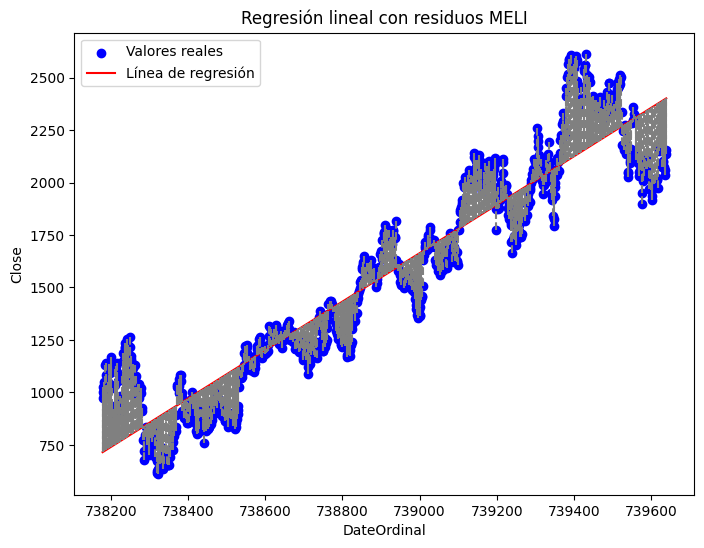

In [8]:
# 2c. Grafica de las diferencias entre los valores reales y los valores ajustados, la linea de regresion y los puntos, ademas de Dibujar líneas verticales que representan los residuos

import matplotlib.pyplot as plt

# Gráfica de dispersión con la línea de regresión y residuos
plt.figure(figsize=(8, 6))
plt.scatter(data['DateOrdinal'], data['Close'], color='blue', label='Valores reales')
plt.plot(data['DateOrdinal'], data['y_pred'], color='red', label='Línea de regresión')
plt.xlabel('DateOrdinal')
plt.ylabel('Close')
plt.title(f'Regresión lineal con residuos {TICKER}')

# Dibujar líneas verticales que representan los residuos
for index, row in data.iterrows():
    plt.plot([row['DateOrdinal'], row['DateOrdinal']], [row['Close'], row['y_pred']], color='gray', linestyle='--')

# Gráfica de las diferencias
#plt.scatter(df['x1'], df['diferencia'], color='green', label='Diferencias')
#plt.axhline(y=0, color='black', linestyle='--')  # Línea horizontal en y=0

plt.legend()
plt.show()

In [9]:
# 2d. Valores ajustados y residuales
y_hat = results.fittedvalues
residuals = results.resid

# Propiedades algebraicas de los estadísticos MCO
print("Suma de los residuales:", np.sum(residuals))
print("Media de los residuales:", np.mean(residuals))
print("Covarianza entre X y los residuales:", np.cov(X['DateOrdinal'], residuals)[0, 1])
print("Covarianza entre X y los valores ajustados:", np.cov(X['DateOrdinal'], y_hat)[0, 1])

# Bondad de ajuste
print("R-cuadrado:", results.rsquared)

Suma de los residuales: 1.2300442904233932e-06
Media de los residuales: 1.2251437155611487e-09
Covarianza entre X y los residuales: -5.255519214679569e-10
Covarianza entre X y los valores ajustados: 206066.6564514115
R-cuadrado: 0.8710986405939587



* **Suma de los residuales:** Este valor es muy cercano a cero, lo cual es una propiedad de la regresión de Mínimos Cuadrados Ordinarios (MCO). La suma de las diferencias entre los valores reales y los valores predichos teóricamente debería ser cero. El pequeño valor distinto de cero se debe a la precisión de punto flotante.
* **Media de los residuales:** Al igual que la suma, la media de los residuales también es muy cercana a cero, lo cual es otra propiedad de MCO.
* **Covarianza entre X y los residuales:** Este valor también es muy cercano a cero. En MCO, los residuales no están correlacionados con las variables independientes (en este caso, `DateOrdinal`). Esto indica que el modelo está capturando la relación lineal entre la variable independiente y la variable dependiente.
* **Covarianza entre X y los valores ajustados:** Este valor muestra la covarianza entre la variable independiente (`DateOrdinal`) y los valores predichos (`y_hat`). Una covarianza distinta de cero aquí es esperada, ya que los valores predichos son una función lineal de la variable independiente. El valor negativo indica una relación lineal negativa entre la fecha y el precio de cierre predicho.
* **R-cuadrado:** El valor de R-cuadrado es 0.196. Esto indica que aproximadamente el 19.6% de la varianza en la variable dependiente (precio de cierre) puede ser explicada por la variable independiente (DateOrdinal) en este modelo de regresión lineal. Un R-cuadrado bajo sugiere que el modelo no explica una gran parte de la variabilidad en los datos, y otros factores probablemente influyen en el precio de cierre.

In [10]:
# =========================
# 3) Predicción a 100 días con intervalos (get_prediction)
# =========================
last_date = data["Date"].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=101, freq="D")[1:]  # 100 días futuros
future_ordinals = future_dates.map(pd.Timestamp.toordinal)
X_future = sm.add_constant(future_ordinals)

# get_prediction: obtiene media predicha + IC de la media + IC observacional
pred = results.get_prediction(X_future)
pred_df = pred.summary_frame(alpha=0.05)  # 95% (cámbialo si quieres)

# Ensamblar DataFrame de pronóstico
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Mean": pred_df["mean"].values,
    "Mean_CI_Lower": pred_df["mean_ci_lower"].values,
    "Mean_CI_Upper": pred_df["mean_ci_upper"].values,
    "Obs_CI_Lower": pred_df["obs_ci_lower"].values,  # intervalo de predicción (más ancho)
    "Obs_CI_Upper": pred_df["obs_ci_upper"].values
})

print("\n=== Primeras 10 predicciones con IC ===")
print(forecast_df.head(10))




=== Primeras 10 predicciones con IC ===
        Date  Predicted_Mean  Mean_CI_Lower  Mean_CI_Upper  Obs_CI_Lower  \
0 2026-01-24     2401.959603    2378.685085    2425.234122   2032.872538   
1 2026-01-25     2403.113987    2379.815615    2426.412358   2034.025417   
2 2026-01-26     2404.268370    2380.946138    2427.590603   2035.178293   
3 2026-01-27     2405.422754    2382.076652    2428.768855   2036.331168   
4 2026-01-28     2406.577137    2383.207159    2429.947116   2037.484040   
5 2026-01-29     2407.731521    2384.337657    2431.125384   2038.636911   
6 2026-01-30     2408.885904    2385.468148    2432.303661   2039.789779   
7 2026-01-31     2410.040288    2386.598630    2433.481946   2040.942646   
8 2026-02-01     2411.194671    2387.729105    2434.660238   2042.095510   
9 2026-02-02     2412.349055    2388.859571    2435.838539   2043.248372   

   Obs_CI_Upper  
0   2771.046668  
1   2772.202557  
2   2773.358447  
3   2774.514340  
4   2775.670234  
5   2776.82613

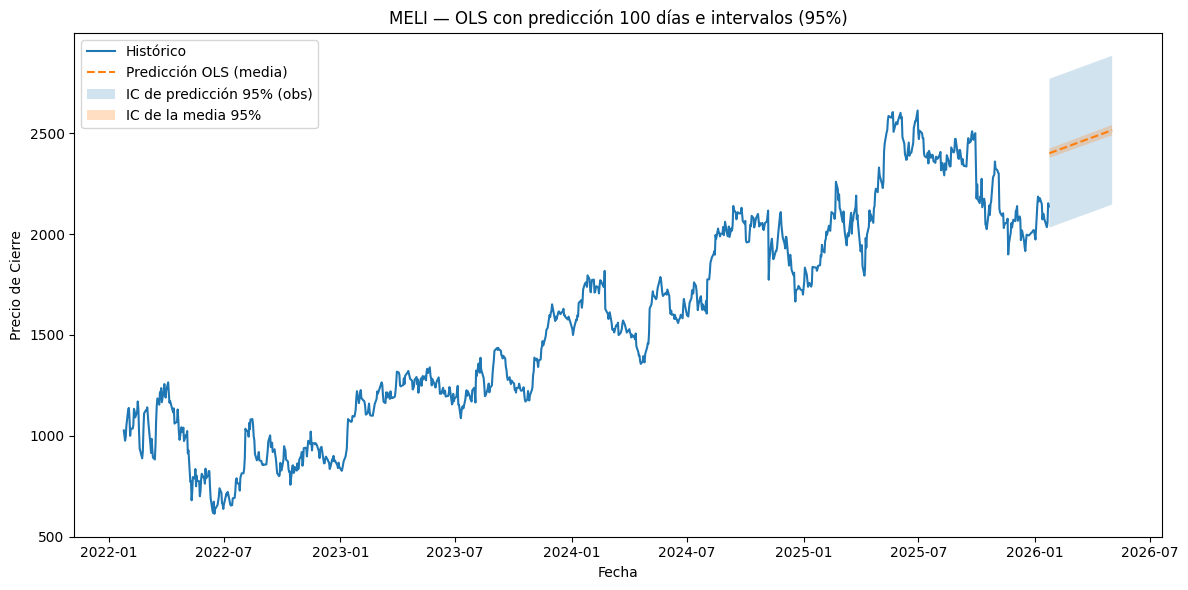

In [11]:
# =========================
# 4) Gráfico histórico + predicción con bandas
# =========================
plt.figure(figsize=(12,6))
plt.plot(data["Date"], data["Close"], label="Histórico")
plt.plot(forecast_df["Date"], forecast_df["Predicted_Mean"], linestyle="--",
         label="Predicción OLS (media)")

# Bandas: Intervalo de predicción (obs_ci) — suele ser el más útil para futuros observados
plt.fill_between(forecast_df["Date"],
                 forecast_df["Obs_CI_Lower"],
                 forecast_df["Obs_CI_Upper"],
                 alpha=0.2, label="IC de predicción 95% (obs)") # IC: Intervalo de Confianza

# (Opcional) Bandas de IC de la media
plt.fill_between(forecast_df["Date"],
                 forecast_df["Mean_CI_Lower"],
                 forecast_df["Mean_CI_Upper"],
                 alpha=0.25, label="IC de la media 95%")

plt.title(f"{TICKER} — OLS con predicción 100 días e intervalos (95%)")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.legend()
plt.tight_layout()
plt.show()



In [12]:
# =========================
# 5) Métricas en entrenamiento (MSE/RMSE)
# =========================
y_pred_train = results.fittedvalues
mse_ols = mean_squared_error(y, y_pred_train)
rmse_ols = float(np.sqrt(mse_ols))
print(f"\nOLS -> MSE: {mse_ols:.4f} | RMSE: {rmse_ols:.4f}")




OLS -> MSE: 35165.3729 | RMSE: 187.5243




* OLS -> MSE: 211.6451: El Error Cuadrático Medio (MSE) para el modelo OLS en el conjunto de entrenamiento es 211.6451. El MSE representa la media de los errores al cuadrado, indicando qué tan lejos están, en promedio, los valores predichos de los valores reales. Un MSE más bajo indica un mejor ajuste del modelo a los datos de entrenamiento.

* OLS -> RMSE: 14.5480: La Raíz del Error Cuadrático Medio (RMSE) para el modelo OLS en el conjunto de entrenamiento es 14.5480. El RMSE es la raíz cuadrada del MSE y se expresa en las mismas unidades que la variable dependiente (en este caso, el precio de cierre). Esto lo hace más interpretable que el MSE. Un RMSE de 14.5480 significa que, en promedio, las predicciones del modelo OLS se desvían aproximadamente en 14.55 unidades del precio de cierre real en el conjunto de entrenamiento.

En el contexto de la predicción de precios de acciones, un RMSE de 14.55 puede considerarse relativamente alto, especialmente si la volatilidad del precio de la acción es baja. Como se menciona en el resumen, el modelo OLS lineal simple es una gran simplificación para predecir precios de acciones y el bajo R-cuadrado (0.189) confirma que explica una pequeña parte de la variabilidad del precio. La comparación posterior con el modelo Naive (que tiene un RMSE mucho menor) también sugiere que el modelo OLS lineal no es un buen predictor en este caso particular.

## Naive (Benchmark) para comparar nuestro modelo

Queremos que el resultado RMSE del OLS sea menor que el RMSE del Naive y que ambos sean Buenos (<2%) o Aceptables (2%-5%) pero no Malos (>5%)

In [13]:
# =========================
# 6) Naive (Benchmark) y comparación OLS
# =========================
y_naive = data["Close"].shift(1).dropna()
y_real  = data["Close"].iloc[1:]  # Alinear
mse_naive = mean_squared_error(y_real, y_naive)
rmse_naive = float(np.sqrt(mse_naive))

#porcentaje de RMSE con respecto a ultimo Close Price
rmse_ols_perc = rmse_ols/data["Close"].iloc[-1]
rmse_naive_perc = rmse_naive/data["Close"].iloc[-1]


# Summary

print("Ticker:", TICKER)
print("Periodo:",PERIOD)
print("Intervalo:",INTERVAL)
print("Close: $",round(data["Close"].iloc[-1],2))
print("2% (Bueno): $",round(data["Close"].iloc[-1]*0.02,2))
print("5% (Aceptable): $",round(data["Close"].iloc[-1]*0.05,2))
print(f"OLS   -> MSE: {mse_ols:.4f} | RMSE: ${rmse_ols:.4f} ({round(rmse_ols_perc*100,2)}%)") 
print( "OLS RMSE es Bueno (<2%)" if rmse_ols_perc <= 0.02 else "OLS RMSE es Aceptable (2 al 5%)" if rmse_ols_perc < 0.05 else "OLS RMSE es Malo (>5%)" )
print(f"Naive -> MSE: {mse_naive:.4f} | RMSE: ${rmse_naive:.4f} ({round(rmse_naive/data["Close"].iloc[-1]*100,2)}%)")
print( "Naive RMSE es Bueno (<2%)" if rmse_naive_perc <= 0.02 else "Naive RMSE es Aceptable (2% al 5%)" if rmse_naive_perc < 0.05 else "Naive RMSE es Malo (>5%)" )
print("\nConclusion:")
print( "\n OLS RMSE es Bueno porque es menor que el RMSE Naive y ademas es < al 5% (aceptable)" 
      if rmse_ols_perc <= rmse_naive_perc and rmse_ols_perc < 0.05 
      else "OLS RMSE es Malo porque NO es menor que RMSE Naive y es > al 5%" )



# TO-DO
# correr este algoritmo para varios periodos 2y, etc.. e incluir el TS1001 WLS
# hacer esto para diferentes stocks

Ticker: MELI
Periodo: 4y
Intervalo: 1d
Close: $ 2137.29
2% (Bueno): $ 42.75
5% (Aceptable): $ 106.86
OLS   -> MSE: 35165.3729 | RMSE: $187.5243 (8.77%)
OLS RMSE es Malo (>5%)
Naive -> MSE: 1868.6635 | RMSE: $43.2280 (2.02%)
Naive RMSE es Aceptable (2% al 5%)

Conclusion:
OLS RMSE es Malo porque NO es menor que RMSE Naive y es > al 5%




🔎 Explicación paso a paso:

	1.	Naive predictor (pronóstico ingenuo):

y_naive = data["Close"].shift(1).dropna()

	•	shift(1) desplaza toda la columna de precios 1 día hacia abajo.
	•	Es decir, el valor predicho para hoy será simplemente el precio de ayer.
	•	Este es el modelo naive, usado como baseline en series financieras.

👉 Ejemplo:

	•	Precio ayer: 100 USD
	•	Precio hoy (predicho por naive): 100 USD



	2.	Valores reales alineados:

y_real = data["Close"].iloc[1:]

	•	iloc[1:] elimina el primer valor (porque no tiene un “día anterior” para comparar).
	•	Así, y_real y y_naive quedan alineados en el mismo índice temporal.
👉 Ambos ahora tienen la misma longitud y representan:

	•	y_naive: predicciones del modelo naive.
	
	•	y_real: precios observados reales.


	3.	Error cuadrático medio (MSE):

mse_naive = mean_squared_error(y_real, y_naive)

	•	Calcula el promedio del cuadrado de los errores entre predicción naive y valor real.
	•	Fórmula:
$$
MSE = \frac{1}{n} \sum_{t=1}^{n} (y_t - \hat{y}_t)^2
$$
	•	Mientras más bajo, mejor la predicción.


	4.	Raíz del error cuadrático medio (RMSE):

rmse_naive = float(np.sqrt(mse_naive))

	•	Toma la raíz cuadrada del MSE.
	•	Interpretable en las mismas unidades que el precio (USD).
	•	Ejemplo: RMSE = 5 significa que, en promedio, el error típico es de 5 USD.



✅ Conclusión:

Este bloque implementa un baseline ingenuo en predicción financiera:

	•	Predicción naive: “el precio de mañana será igual al de hoy”.
	•	MSE/RMSE: sirven para medir qué tan lejos está tu modelo de esta predicción mínima.
	•	👉 Si tu modelo no mejora el RMSE del naive predictor, entonces no aporta valor.

